In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack, issparse, csr_matrix
from numpy import hstack as nhstack

from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, LinearSVR

import sys
sys.path.append('../../')
from poe_price.data import select
import poe_price.feature as feature
import poe_price.preprocessing as prepro

# Data

In [2]:
currency = select.get_currency()
items = select.get_jewels()

In [3]:
currency.shape[0], len(items['items'])

(4528, 156615)

# Features

In [4]:
X = []

In [5]:
# FUNCTIONS
X.append(feature.corrupted(items))
X.append(feature.duplicated(items))
X.append(feature.identified(items))
X.append(feature.suffixes_subcount(items))
# X.append(feature.requirements(items))
# X.append(feature.veiled(items))
# X.append(feature.influences(items))
# features.append(feature.sockets(items))
X.append(feature.is_abyss_jewel(items))

# CLASSES
X.append(feature.Modifiers(how='mean').fit_transform(items))
X.append(feature.Rarity().fit_transform(items))
# X.append(feature.Properties(how='mean').fit_transform(items))
# X.append(feature.Category().fit_transform(items))
# X.append(feature.SubCategories().fit_transform(items))

In [6]:
for i, feat in enumerate(X):
    if not issparse(feat):
        X[i] = csr_matrix(feat)
X = hstack(X).tocsr()

In [7]:
y = feature.Price().fit_transform(items, currency)

# Preprocessing

In [8]:
X, y = prepro.price_bounds_row_removal(X, y, 1, 10000)

print(X.shape[1])
X = prepro.remove_empty_features(X)
print(X.shape[1])


287
287


In [42]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

TypeError: MinMaxScaler does not support sparse input. Consider using MaxAbsScaler instead.

In [9]:
X_scaler = RobustScaler(with_centering=False)
y_scaler = RobustScaler(with_centering=False)
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

In [17]:
X_scaler = StandardScaler(with_mean=False)
y_scaler = StandardScaler(with_mean=False)
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.25, random_state=0)

# Regression Models

In [11]:
def get_metrics(y_train, y_test, y_train_pred, y_test_pred):
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    return r2_train, r2_test, mae_train, mae_test, mse_train, mse_test


In [22]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

get_metrics(y_train, y_test, y_train_pred, y_test_pred)

In [28]:
regressor = LinearSVR(random_state=0)
regressor.fit(X_train, y_train)

y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

get_metrics(y_train, y_test, y_train_pred, y_test_pred)

(-0.0011653053391398327,
 0.0018209162209695817,
 1.3390076362259582,
 1.3215277407410986,
 40.78367176094884,
 21.769184400105264)

In [ ]:
regressor = SVR()
regressor.fit(X_train, y_train)

y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

get_metrics(y_train, y_test, y_train_pred, y_test_pred)

In [16]:
regressor = RandomForestRegressor(n_estimators=10, random_state=0)
regressor.fit(X_train, y_train)

y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

get_metrics(y_train, y_test, y_train_pred, y_test_pred)

/home/fabio/.conda/envs/ds_poe_price/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


(0.8448961714845441,
 0.07710605356289602,
 0.52185596773542,
 1.3599368766456295,
 2.898193280018801,
 17.418853400164362)

## Exploiting best model

In [11]:
kf = KFold(n_splits=10, shuffle=False, random_state=0)
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    regressor = RandomForestRegressor(n_estimators=10, random_state=0)
    regressor.fit(X_train, y_train)

    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)

    print(get_metrics(y_train, y_test, y_train_pred, y_test_pred))

/home/fabio/Desktop/poe_price/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/fabio/Desktop/poe_price/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


(0.8283286394171786, 0.40836768054812156, 8.855283645033495, 19.589328112316405, 1503.1825703892785, 7907.040376855415)


/home/fabio/Desktop/poe_price/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


(0.8578265387844374, -0.24823393964145657, 8.649814430247073, 22.019856220463826, 1394.734167623298, 4843.375131438703)


/home/fabio/Desktop/poe_price/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


(0.8486204178813296, -0.23715598673295624, 8.628568714596506, 22.62871049553004, 1454.0510016939465, 7079.704102587204)


/home/fabio/Desktop/poe_price/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


(0.8505291589083936, -0.18745136598105416, 8.61354950141195, 23.07026377786637, 1434.3296800622452, 6895.191597588732)


/home/fabio/Desktop/poe_price/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


(0.8502076429795309, 0.036557140549003386, 8.585371847664923, 22.692736997062443, 1284.8077762139608, 14428.162060343158)


/home/fabio/Desktop/poe_price/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


(0.8403686980755035, -0.09782497896731068, 8.756168932929716, 22.069065427471287, 1555.986232937615, 4878.718794575504)


/home/fabio/Desktop/poe_price/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


KeyboardInterrupt: 

In [ ]:
grid = {
    "n_estimators": range(10, 100, 20),
}

gs = GridSearchCV(RandomForestRegressor, grid, n_jobs=2, verbose=True)

## Deep learning

In [24]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [41]:
model = Sequential()
model.add(Dense(200, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(400, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 200)               57600     
_________________________________________________________________
dropout_11 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 400)               80400     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 401       
Total params: 178,601
Trainable params: 178,601
Non-trainable params: 0
________________________________________________

In [45]:
history = model.fit(X_train, y_train, epochs=100, batch_size=1000,  verbose=1, validation_split=0.4)

Train on 69735 samples, validate on 46491 samples
Epoch 1/100
69735/69735 [==============================] - 2s 27us/step - loss: 9.5719 - mae: 1.5112 - val_loss: 9.4267 - val_mae: 1.3314
Epoch 2/100
69735/69735 [==============================] - 2s 24us/step - loss: 8.8156 - mae: 1.4353 - val_loss: 9.0819 - val_mae: 1.2815
Epoch 3/100
69735/69735 [==============================] - 2s 23us/step - loss: 8.4502 - mae: 1.3915 - val_loss: 8.8134 - val_mae: 1.2467
Epoch 4/100
69735/69735 [==============================] - 2s 23us/step - loss: 8.0255 - mae: 1.3596 - val_loss: 8.7367 - val_mae: 1.2083
Epoch 5/100
69735/69735 [==============================] - 2s 23us/step - loss: 7.5931 - mae: 1.3267 - val_loss: 8.4246 - val_mae: 1.2340
Epoch 6/100
69735/69735 [==============================] - 2s 24us/step - loss: 7.2250 - mae: 1.2952 - val_loss: 8.4548 - val_mae: 1.1892
Epoch 7/100
69735/69735 [==============================] - 2s 24us/step - loss: 6.9164 - mae: 1.2766 - val_loss: 8.4275 - 

### Plotting metrics

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


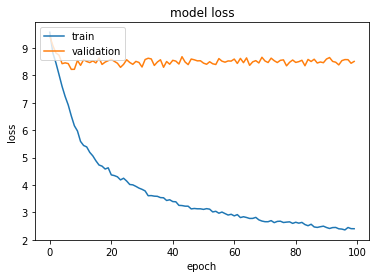

In [46]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()